# <center> Relax Inc Data Science Challenge </center>

## Libraries & Modules

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns

#from sklearn.utils import resample
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from scipy.stats import chi2_contingency
#from sklearn.metrics import roc_auc_score
import warnings # For handling error messages.

## Data Wrangling

In [200]:
# read in the "engagement" CSV file and take a quick peak
df_engage = pd.read_csv("takehome_user_engagement.csv")
df_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [201]:
# check the columns' statistics and data types, as well as if there are null values
print(df_engage.describe())
print(df_engage.info())

             user_id   visited
count  207917.000000  207917.0
mean     5913.314197       1.0
std      3394.941674       0.0
min         1.000000       1.0
25%      3087.000000       1.0
50%      5682.000000       1.0
75%      8944.000000       1.0
max     12000.000000       1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


In [202]:
# read in the "users" CSV file and take a quick peak
df_users = pd.read_csv("takehome_users.csv",encoding='latin-1')
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [203]:
# check the columns' statistics and data types, as well as if there are null values
print(df_users.describe())
print(df_users.info())

         object_id  last_session_creation_time  opted_in_to_mailing_list  \
count  12000.00000                8.823000e+03              12000.000000   
mean    6000.50000                1.379279e+09                  0.249500   
std     3464.24595                1.953116e+07                  0.432742   
min        1.00000                1.338452e+09                  0.000000   
25%     3000.75000                1.363195e+09                  0.000000   
50%     6000.50000                1.382888e+09                  0.000000   
75%     9000.25000                1.398443e+09                  0.000000   
max    12000.00000                1.402067e+09                  1.000000   

       enabled_for_marketing_drip        org_id  invited_by_user_id  
count                12000.000000  12000.000000         6417.000000  
mean                     0.149333    141.884583         5962.957145  
std                      0.356432    124.056723         3383.761968  
min                      0.000000  

In [204]:
# change timestamp to datetime in df_engage
df_engage["time_stamp"] = pd.to_datetime(df_engage["time_stamp"])
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


## Finding adopted users

In [210]:
# sort the rows in df_engage in ascending order of user_id, and ascending order of timestamp for each user_id
df_engage.sort_values(['user_id', 'time_stamp'], ascending=[True, True]).head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [208]:
# Since adopted users must have had at least 3 "engagement" entries, 
# we can filter to only keeps users with 3 or more rows in df_engage
removals = df_engage['user_id'].value_counts().reset_index()
removals = removals[removals['user_id'] >= 3]['index'].values
filtered_df = df_engage[df_engage['user_id'].isin(removals)]
filtered_df.head()

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


In [209]:
# Since the adopted users must have had 3 entries on different days in a 7-day span,
# we can delete rows with common days for each user_id
filtered_df["time_stamp"] = filtered_df["time_stamp"].astype('M8[D]')
clean_df = filtered_df.drop_duplicates(
    subset = ['time_stamp', 'user_id'],
    keep = 'last').reset_index(drop = True)
clean_df.head()

<ipython-input-209-04184dc302a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["time_stamp"] = filtered_df["time_stamp"].astype('M8[D]')


,time_stamp,user_id,visited
0,2013-11-15,2,1
1,2013-11-29,2,1
2,2013-12-09,2,1
3,2013-12-25,2,1
4,2013-12-31,2,1


In [211]:
# With the above data wrangling, df_clean only contains users who have at least 3 entries
# Therefore for each user, we can check if the date difference between an engagement and 
# two engagements before are within 7 days within each other. If yes, we store this user
# in a new adopted_user list
adopted_user = []
for id in clean_df.user_id.unique():
    for i in range(2,len(clean_df[clean_df['user_id']==id]['time_stamp'])):
        if (clean_df[clean_df['user_id']==id]['time_stamp'].values[i-2] + np.timedelta64(7,'D')) > (clean_df[clean_df['user_id']==id]['time_stamp'].values[i]):
            adopted_user.append(id)
            break

In [216]:
# Let's check what proportion of users are adopted
print("Proportion of users who were adopted are {:.1%}.".format(len(adopted_user)/len(df_users)))

Proportion of users who were adopted are 13.4%.


## Checking for factors affecting user adoption

In [217]:
# Add a column to store whether a user is adopted or not in df_users
df_users['adopted'] = np.where(df_users["object_id"].isin(adopted_user), 1, 0)
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [218]:
# extact email provider from the email column
df_users['email_comp'] = [x.split('@')[1].split('.')[0] for x in df_users['email']]
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,email_comp
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,yahoo
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,gustr
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,gustr
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,yahoo
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,yahoo


In [219]:
# Create a new column "usage_span" to store how long has a user been using the service
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'], format='%Y-%m-%d %H:%M:%S')
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit='s')
df_users['usage_span'] = (df_users['last_session_creation_time'] - df_users['creation_time']).dt.days
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,email_comp,usage_span
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,gustr,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,gustr,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,yahoo,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,yahoo,5.0


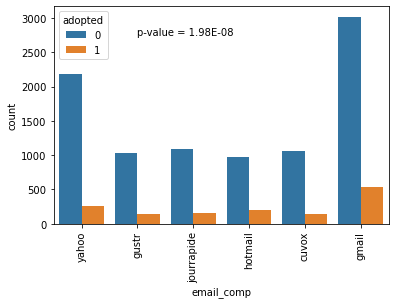

In [251]:
# Check if email providers play a role in determining adoption of users
# because there are many email providers, we will consider only the top 6
crosstab = pd.crosstab(df_users['email_comp'], df_users['adopted'])
top_emails = list(crosstab[0].sort_values(ascending=False)[:6].index)
crosstab = pd.crosstab(df_users[df_users['email_comp'].isin(top_emails)]['email_comp'], 
                       df_users[df_users['email_comp'].isin(top_emails)]['adopted'])
_ = sns.countplot(x='email_comp', data=df_users[df_users['email_comp'].isin(top_emails)], hue='adopted')
_ = plt.xticks(rotation=90)
results = chi2_contingency(crosstab)
_ = plt.text(1, 2750, 
             'p-value = {:.2E}'.format(results[1]), fontsize = 10)


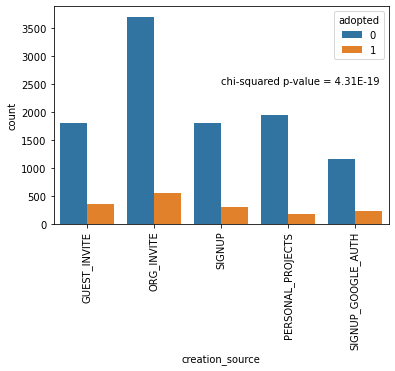

In [257]:
# Does creation source have an impact on user adoption?
_ = sns.countplot(x='creation_source', data=df_users, hue='adopted')
_ = plt.xticks(rotation=90)
crosstab = pd.crosstab(df_users['creation_source'], df_users['adopted'])
results = chi2_contingency(crosstab)
_ = plt.text(2, 2500, 
             'chi-squared p-value = {:.2E}'.format(results[1]), fontsize = 10)

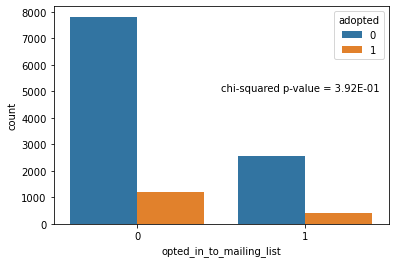

In [255]:
# Does opting for mailing list have an impact on user adoption?
_ = sns.countplot(x='opted_in_to_mailing_list', data=df_users, hue='adopted')
_ = plt.xticks(rotation=0)
crosstab = pd.crosstab(df_users['opted_in_to_mailing_list'], df_users['adopted'])
results = chi2_contingency(crosstab)
_ = plt.text(0.5, 5000, 'chi-squared p-value = {:.2E}'.format(results[1]), fontsize = 10)

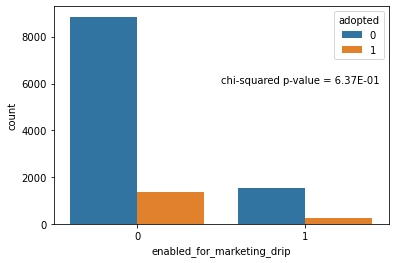

In [258]:
# Does enabling marketing drip have an impact on user adoption?
_ = sns.countplot(x='enabled_for_marketing_drip', data=df_users, hue='adopted')
_ = plt.xticks(rotation=0)
crosstab = pd.crosstab(df_users['enabled_for_marketing_drip'], df_users['adopted'])
results = chi2_contingency(crosstab)
_ = plt.text(0.5, 6000, 'chi-squared p-value = {:.2E}'.format(results[1]), fontsize = 10)

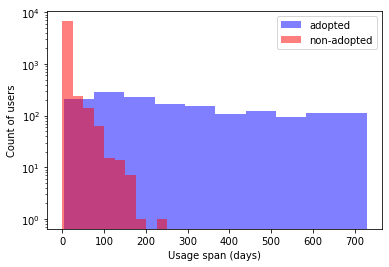

In [260]:
# Distribution of usage span of users
_ = plt.hist(df_users[df_users['adopted']==1]['usage_span'], alpha=0.5, color='b', label='adopted')
_ = plt.hist(df_users[df_users['adopted']==0]['usage_span'], alpha=0.5, color='r', label='non-adopted')
_ = plt.yscale('log')
_ = plt.legend()
_ = plt.xlabel("Usage span (days)")
_ = plt.ylabel('Count of users')

## Summary and recommendation

The proportion of adopted users from the given user database is: **13.4%**

From the above tests of the different available features, we can see that none of the features have a strong statistical difference between users who were adopted versus users who weren't; except for usage span of the users. Evidently, users who have had a long usage span (number of days between date of account creation and date of last usage) are more likely to fall into the category of adopted users.

Other than this, the above analysis also shows the most frequent values for the following fields:
* email provider: **gmail**
* creation source: **org_invite**
* opted in to mailing list: **No**
* enabled for marketing drip: **No**

Given the insignificant gain in adoption rate through mailing list and marketing drip, my recommendation for the company would be to not over-invest in these resources.